In [35]:
comment = 'bn_all_shuffle_sgd_lrd_095'

In [36]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd#
%matplotlib inline
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import time

In [37]:
from Code.Models.c7o2h10_model import DeepPotential, train, normalize, backtransform
from Code.DataGeneration.saver import create_path

In [38]:
data_path = './Dataset/c7o2h10_X.npy'
label_path = './Dataset/c7o2h10_Y.npy'
train_ids_path = './Dataset/iso17/train_ids.txt'
test_ids_path = './Dataset/iso17/validation_ids.txt'
model_path = './ModelCheckpoints/c7o2h10/'
model_path = './ModelCheckpoints/c7o2h10/{}/'.format(comment)

In [39]:
use_cuda = torch.cuda.is_available()
print('use cuda:  ', use_cuda)

use cuda:   True


# Read the Data

In [40]:
train_ids = (np.loadtxt(train_ids_path) - 1).astype(int).tolist()
test_ids = (np.loadtxt(test_ids_path) - 1).astype(int).tolist()

In [41]:
X_npy = np.load(data_path)
Y_npy = np.load(label_path) * -1
Y_npy, Y_min, Y_max = normalize(Y_npy)
X_npy.shape

(404000, 19, 72)

### Split into test and train

In [42]:
X_train_npy, X_test_npy = X_npy[train_ids], X_npy[test_ids]
Y_train_npy, Y_test_npy = Y_npy[train_ids], Y_npy[test_ids]

In [43]:
X_train = Variable(torch.Tensor(X_train_npy))
Y_train = Variable(torch.Tensor(Y_train_npy), requires_grad=False)
X_test = Variable(torch.Tensor(X_test_npy))
Y_test = Variable(torch.Tensor(Y_test_npy), requires_grad=False)

## Test Model

0:	test scoore:     0.3478		train scoore:     0.3422
1:	test scoore:     0.3080		train scoore:     0.3159
2:	test scoore:     0.2863		train scoore:     0.2868
3:	test scoore:     0.2811		train scoore:     0.2782
4:	test scoore:     0.2723		train scoore:     0.2623
5:	test scoore:     0.2666		train scoore:     0.2577
6:	test scoore:     0.2618		train scoore:     0.2708
7:	test scoore:     0.2609		train scoore:     0.2644
8:	test scoore:     0.2555		train scoore:     0.2470
9:	test scoore:     0.2513		train scoore:     0.2441
10:	test scoore:     0.2517		train scoore:     0.2442
11:	test scoore:     0.2484		train scoore:     0.2489
12:	test scoore:     0.2478		train scoore:     0.2364
13:	test scoore:     0.2495		train scoore:     0.2320
14:	test scoore:     0.2435		train scoore:     0.2405
15:	test scoore:     0.2424		train scoore:     0.2436
16:	test scoore:     0.2463		train scoore:     0.2293
17:	test scoore:     0.2404		train scoore:     0.2299
18:	test scoore:     0.2423		train sco

FileNotFoundError: [Errno 2] No such file or directory: './error_plots/bn_all_shuffle_sgd_lrd_095/abs_error_1529176516.png'

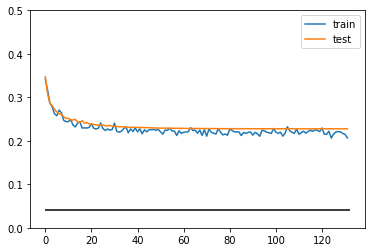

In [44]:
test_scoores = []
train_scoores = []
for i in range(300):
    try:
        test_model = DeepPotential()
        test_model.load_state_dict(torch.load(f'{model_path}epoch_{i}', map_location=lambda storage, loc: storage))
        test_result = np.squeeze(backtransform(test_model(X_test), Y_min, Y_max).detach().numpy())
        val_result = np.squeeze(backtransform(Y_test, Y_min, Y_max).detach().numpy())
        test_scoore = np.round(np.mean(np.abs(test_result - val_result)), 4)
        ids = np.random.randint(0, 400000, 1064)
        #ids = np.arange(0, 10640)
        test_result = np.squeeze(backtransform(test_model(X_train[ids]), Y_min, Y_max).detach().numpy())
        val_result = np.squeeze(backtransform(Y_train[ids], Y_min, Y_max).detach().numpy())
        train_scoore = np.round(np.mean(np.abs(test_result - val_result)), 4)
        print('{}:\ttest scoore: {:10.4f}\t\ttrain scoore: {:10.4f}'.format(i, test_scoore, train_scoore))
        test_scoores.append(test_scoore)
        train_scoores.append(train_scoore)
    except:
        print('not all files available')
        break
plt.plot(train_scoores, label='train')
plt.plot(test_scoores, label='test')
plt.hlines(0.04, 0, len(train_scoores))
plt.legend()
plt.ylim([0, 0.5])
plt.savefig('./error_plots/{}/abs_error_{}'.format(comment, int(time.time())))

In [ ]:
test_model = DeepPotential()
test_model.load_state_dict(torch.load(f'ModelCheckpoints/c7o2h10/epoch_{i-1}', map_location=lambda storage, loc: storage))    
single_scoores = []
for data_point in range(X_train.shape[0]):
    test_result = np.squeeze(backtransform(test_model(X_train[data_point].reshape(1, 19, 72)), Y_min, Y_max).detach().numpy())
    val_result = np.squeeze(backtransform(Y_train[data_point].reshape(1, 19, 72), Y_min, Y_max).detach().numpy())
    train_scoore = np.round(np.mean(np.abs(test_result - val_result)), 4)
    single_scoores.append(train_scoore)
    print(data_point/X_train.shape, )

In [ ]:
X_train[0].reshape(1, 19, 72).shape

In [32]:
test_result = np.squeeze(backtransform(test_model(X_train[:100]), Y_min, Y_max).detach().numpy())
val_result = np.squeeze(backtransform(Y_train[:100], Y_min, Y_max).detach().numpy())
scoore = np.mean(np.abs(test_result - val_result))

In [33]:
test_result[:15]

array([11502.016, 11502.575, 11501.767, 11502.003, 11502.35 , 11501.663,
       11502.635, 11501.526, 11501.991, 11501.933, 11502.364, 11501.679,
       11502.417, 11502.456, 11501.469], dtype=float32)

In [34]:
val_result[:15]

array([11504.473, 11503.904, 11503.876, 11503.75 , 11503.702, 11504.173,
       11504.118, 11504.307, 11504.022, 11504.65 , 11504.383, 11503.74 ,
       11503.798, 11503.842, 11503.797], dtype=float32)

In [ ]:
scoore

In [ ]:
test_model.load_state_dict(torch.load(f'ModelCheckpoints/c7o2h10/epoch_{270}', map_location=lambda storage, loc: storage))
test_result = np.squeeze(backtransform(test_model(X_test), Y_min, Y_max).detach().numpy())
val_result = np.squeeze(backtransform(Y_test, Y_min, Y_max).detach().numpy())

In [ ]:
test_result[:100]

In [ ]:
val_result[:100]

# Testing

## Test normalize function:

In [ ]:
Y_load = np.load(label_path) * -1
Y_normed, Y_min, Y_max = normalize(Y_load)
Y_back = backtransform(Y_normed, Y_min, Y_max)
np.testing.assert_array_almost_equal(Y_back, Y_load)

In [ ]:
x = np.arange(0, 9).reshape(3, 3)

In [ ]:
x

In [ ]:
shuffle = np.arange(0, 3)
np.random.shuffle(shuffle)
shuffle

In [ ]:
x[shuffle]